<a href="https://colab.research.google.com/github/12jeong/Kaggle-beginner/blob/master/Santander-Product-Recommendation-Competition/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

google colab & kaggle API

In [0]:
from tensorflow.python.client import device_lib
import platform

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
!pip install kaggle
from google.colab import files
files.upload()

In [0]:
ls -1ha kaggle.json

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

In [0]:
! kaggle competitions download -c santander-product-recommendation 

In [0]:
!unzip train_ver2.csv.zip
!unzip test_ver2.csv.zip

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# For Jupyter Notebook
%matplotlib inline
import seaborn as sns

In [0]:
trn = pd.read_csv('train_ver2.csv')

#### 분석 목표 : 자사의 고객들을 대상으로 고객 맞춤형 상품 추천을 제공
- 고객의 과거 이력과 유사한 고객군들의 데이터를 기반으로 다음달에 해당 고객이 무슨 상품을 사용할지 예측
- 고객의 만족도를 높임과 동시에 은행 매출에 기여

In [0]:
trn.shape

(13647309, 48)

In [0]:
trn.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [0]:
for col in trn.columns :
    print('{}\n'.format(trn[col].head()))

0    2015-01-28
1    2015-01-28
2    2015-01-28
3    2015-01-28
4    2015-01-28
Name: fecha_dato, dtype: object

0    1375586
1    1050611
2    1050612
3    1050613
4    1050614
Name: ncodpers, dtype: int64

0    N
1    N
2    N
3    N
4    N
Name: ind_empleado, dtype: object

0    ES
1    ES
2    ES
3    ES
4    ES
Name: pais_residencia, dtype: object

0    H
1    V
2    V
3    H
4    V
Name: sexo, dtype: object

0     35
1     23
2     23
3     22
4     23
Name: age, dtype: object

0    2015-01-12
1    2012-08-10
2    2012-08-10
3    2012-08-10
4    2012-08-10
Name: fecha_alta, dtype: object

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: ind_nuevo, dtype: float64

0          6
1         35
2         35
3         35
4         35
Name: antiguedad, dtype: object

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: indrel, dtype: float64

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: ult_fec_cli_1t, dtype: object

0    1
1    1
2    1
3    1
4    1
Name: indrel_1mes, dtype: obje

In [0]:
trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
fecha_dato               object
ncodpers                 int64
ind_empleado             object
pais_residencia          object
sexo                     object
age                      object
fecha_alta               object
ind_nuevo                float64
antiguedad               object
indrel                   float64
ult_fec_cli_1t           object
indrel_1mes              object
tiprel_1mes              object
indresi                  object
indext                   object
conyuemp                 object
canal_entrada            object
indfall                  object
tipodom                  float64
cod_prov                 float64
nomprov                  object
ind_actividad_cliente    float64
renta                    float64
segmento                 object
ind_ahor_fin_ult1        int64
ind_aval_fin_ult1        int64
ind_cco_fin_ult1         int64
ind_cder_fin_ult1  

#### Data Description

##### Numerical Features (굵은 글씨는 범주 또는 더미변수로 취급 가능)
ind~와 관련된 24개의 변수는 은행 상품과 관련된 변수  

|변수명|내용|설명|
|------|---|---|
|ncodpers|Customer code|고객식별번호|
|**ind_nuevo**|New customer Index. 1 if the customer registered in the last 6 months.|6개월 이내 신규고객인 경우 1|
|**indrel**|1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)|1 중요고객 99 해당 달에 중요고객이지만 월말에 해제됨|
|**tipodom**|Addres type. 1, primary address|주소 유형?|
|**cod_prov**|Province code (customer's address)|지방 고객 주소 : nomprov과 관련|
|**ind_actividad_cliente**|Activity index (1, active customer; 0, inactive customer)|활성고객여부|
|renta|Gross income of the household|가계총수입|
|**nd_ahor_fin_ult1~ind_recibo_ult1**|Saving Account(예금) Guarantees(보증)  | Current Account(당좌 예금) Derivada Account(파생 상품 계좌)|
|-|Payroll Account(급여 계좌) Junior Account(청소년 계좌) | Más particular Account, particular Account, particular Plus Account(특별 계좌 상품) |
|-|Short-term deposits(단기 예금) Medium-term deposits(중기 예금) Long-term depostits(장기 예금) | e-count(e-계정) Funds(펀드) Pensions(연금)-2종류|
|-|Mortgage(부동산 대출) Loans(대출) Credic Card(신용카드) | Taxes(세금) Securities(증권) Home Account(홈계정) |
|-|Payroll(급여) Deriect Debit(직불카드)

##### Categorical Features (표시된 변수는 주의 필요)
|변수명|내용|설명|
|------|---|---|
|<span style="color:blue">fecha_dato</span>|The table is partitioned for this column|날짜|
|ind_empleado|Employee index: A active, B ex employed, F filial, N not employee, P pasive|고용지표 A 취업자 B 퇴직or실직 F 자영업? N 실업자|
|pais_residencia|Customer's Country residence|고객 거주 국가|
|sexo|Customer's sex|고객성별|
|<span style="color:red">age</span>|Age|고객나이|
|<span style="color:blue">fecha_alta</span>|The date in which the customer became as the first holder of a contract in the bank|고객 첫 거래 날짜|
|<span style="color:red">antiguedad</span>|Customer seniority (in months)|고객 연봉xx 거래 누적 기간|
|ult_fec_cli_1t|	Last date as primary customer (if he isn't at the end of the month) | 중요고객 만료날짜|
|indrel_1mes|	Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner) | 월초 고객유형 1 2 P 3 4|
|tiprel_1mes |	Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential)| 월초 고객 관계 유형 A I P R | 
|**ndresi**|	Residence index (S (Yes) or N (No) if the residence country is the same than the bank country)| 거주지역이 은행과 일치하면 S |
|**indext**|	Foreigner index (S (Yes) or N (No) if the customer's birth country is different than the bank country)| 태어난 국적이 은행과 다르면 S|
|**conyuemp**|	Spouse index. 1 if the customer is spouse of an employee | 은행 직원의 배우자면 1|
|canal_entrada	|channel used by the customer to join| 고객 유입채널|
|**indfall**	|Deceased index. N/S| 고객 사망 여부|
|nomprov|	Province name| 지방 이름 : cod_prov와 관련|
|segmento|	segmentation: 01 - VIP, 02 - Individuals 03 - college graduated | 고객유형 1 VIP 2 개인 3 대졸자|


In [0]:
# 수치형 변수 추출
num_cols = [col for col in trn.columns[:24] if trn[col].dtype in ['int64','float64']]
trn[num_cols].describe()

,ncodpers,ind_nuevo,indrel,tipodom,cod_prov,ind_actividad_cliente,renta
count,1.364731e+07,1.361958e+07,1.361958e+07,13619574.0,1.355372e+07,1.361958e+07,1.085293e+07
mean,8.349042e+05,5.956184e-02,1.178399e+00,1.0,2.657147e+01,4.578105e-01,1.342543e+05
std,4.315650e+05,2.366733e-01,4.177469e+00,0.0,1.278402e+01,4.982169e-01,2.306202e+05
min,1.588900e+04,0.000000e+00,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03
25%,4.528130e+05,0.000000e+00,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.871098e+04
50%,9.318930e+05,0.000000e+00,1.000000e+00,1.0,2.800000e+01,0.000000e+00,1.018500e+05
75%,1.199286e+06,0.000000e+00,1.000000e+00,1.0,3.500000e+01,1.000000e+00,1.559560e+05
max,1.553689e+06,1.000000e+00,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07


- ind_nuevo : 최대 25%의 고객이 신규고객  
- indrel : 최대 25%의 고객이 월말에 중요고객에서 해지됨
- ind_actividad_cliente : 최소 50%의 고객이 활성고객

In [0]:
# 범주형 변수 추출
cat_cols = [col for col in trn.columns[:24] if trn[col].dtype in ['object']]
trn[cat_cols].describe()

,fecha_dato,ind_empleado,pais_residencia,sexo,age,fecha_alta,antiguedad,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,segmento
count,13647309,13619575,13619575,13619505,13647309,13619575,13647309,24793,13497528.0,13497528,13619575,13619575,1808,13461183,13619575,13553718,13457941
unique,17,5,118,2,235,6756,507,223,13.0,5,2,2,2,162,2,52,3
top,2016-05-28,N,ES,V,23,2014-07-28,0,2015-12-24,1.0,I,S,N,N,KHE,N,MADRID,02 - PARTICULARES
freq,931453,13610977,13553710,7424252,542682,57389,134335,763,7277607.0,7304875,13553711,12974839,1791,4055270,13584813,4409600,7960220


- count를 통해 결측치를 확인할 수 있음 
- ult_fec_cli_1t(중요고객 만료날짜), conyuemp (은행 직원의 배우자여부) 결측치가 매우 많음

In [0]:
trn[cat_cols].describe().iloc[0] < trn.shape[0]

fecha_dato         False
ind_empleado        True
pais_residencia     True
sexo                True
age                False
fecha_alta          True
antiguedad         False
ult_fec_cli_1t      True
indrel_1mes         True
tiprel_1mes         True
indresi             True
indext              True
conyuemp            True
canal_entrada       True
indfall             True
nomprov             True
segmento            True
Name: count, dtype: bool

- fecha_dato는 일년 반, 즉 17개월의 데이터가 있음  
- 23살 고객이 가장 많음
- 고객들의 99.5% ES지역에 산다 (pais_residencia) + 거주지역이 일치함 (indresi)
- 95%의 고객이 태어난 국적과 은행이 다름 (indext) 
- 99.7%의 고객이 살아있음 (indfall)
- 99.9%의 고객이 N : not employee로 되어있음 (ind_empleado) 


In [0]:
# 범주 unique 출력
 for col in cat_cols:
     uniq = np.unique(trn[col].astype(str))
     print('-'*50)
     print('# col {}, n_uniq {}, uniq {}'.format(col,len(uniq),uniq))

--------------------------------------------------
# col fecha_dato, n_uniq 17, uniq ['2015-01-28' '2015-02-28' '2015-03-28' '2015-04-28' '2015-05-28'
 '2015-06-28' '2015-07-28' '2015-08-28' '2015-09-28' '2015-10-28'
 '2015-11-28' '2015-12-28' '2016-01-28' '2016-02-28' '2016-03-28'
 '2016-04-28' '2016-05-28']
--------------------------------------------------
# col ind_empleado, n_uniq 6, uniq ['A' 'B' 'F' 'N' 'S' 'nan']
--------------------------------------------------
# col pais_residencia, n_uniq 119, uniq ['AD' 'AE' 'AL' 'AO' 'AR' 'AT' 'AU' 'BA' 'BE' 'BG' 'BM' 'BO' 'BR' 'BY'
 'BZ' 'CA' 'CD' 'CF' 'CG' 'CH' 'CI' 'CL' 'CM' 'CN' 'CO' 'CR' 'CU' 'CZ'
 'DE' 'DJ' 'DK' 'DO' 'DZ' 'EC' 'EE' 'EG' 'ES' 'ET' 'FI' 'FR' 'GA' 'GB'
 'GE' 'GH' 'GI' 'GM' 'GN' 'GQ' 'GR' 'GT' 'GW' 'HK' 'HN' 'HR' 'HU' 'IE'
 'IL' 'IN' 'IS' 'IT' 'JM' 'JP' 'KE' 'KH' 'KR' 'KW' 'KZ' 'LB' 'LT' 'LU'
 'LV' 'LY' 'MA' 'MD' 'MK' 'ML' 'MM' 'MR' 'MT' 'MX' 'MZ' 'NG' 'NI' 'NL'
 'NO' 'NZ' 'OM' 'PA' 'PE' 'PH' 'PK' 'PL' 'PR' 'PT' 'PY' 'Q

antiguedad : -999999 존재

indrel_1mes : '1', '1.0' 다르게 존재

segmento : object지만 3개의 범주로 나눌 수 있을 듯?

--------------------------------------------------
col: fecha_dato


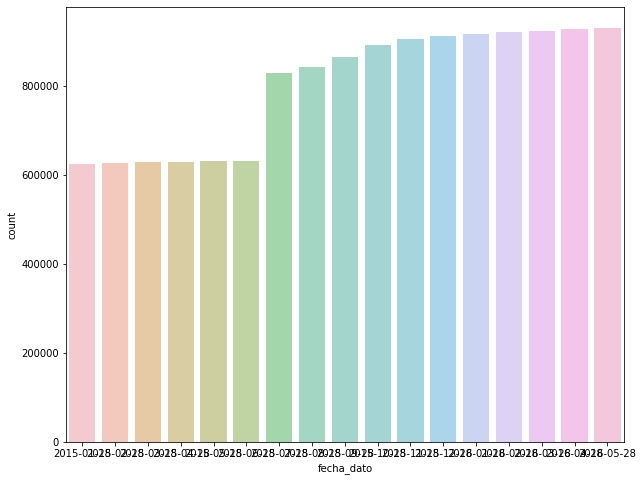

--------------------------------------------------
col: ind_empleado


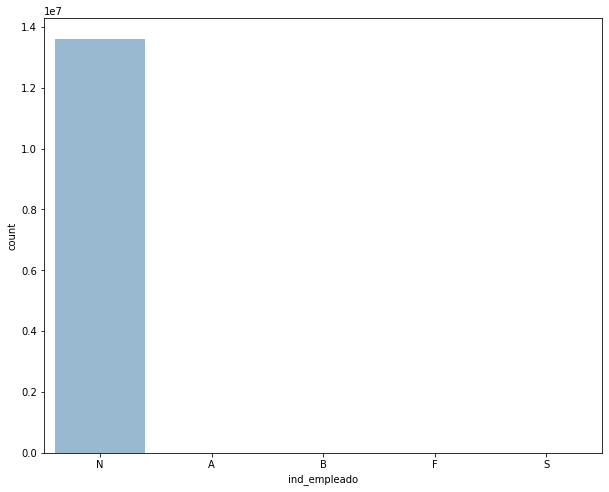

--------------------------------------------------
col: pais_residencia


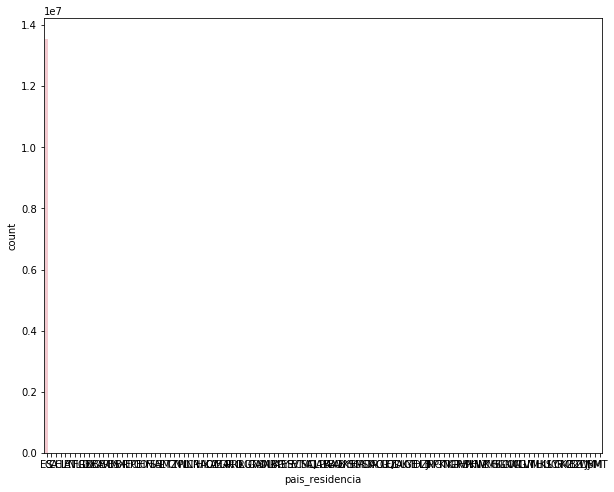

--------------------------------------------------
col: sexo


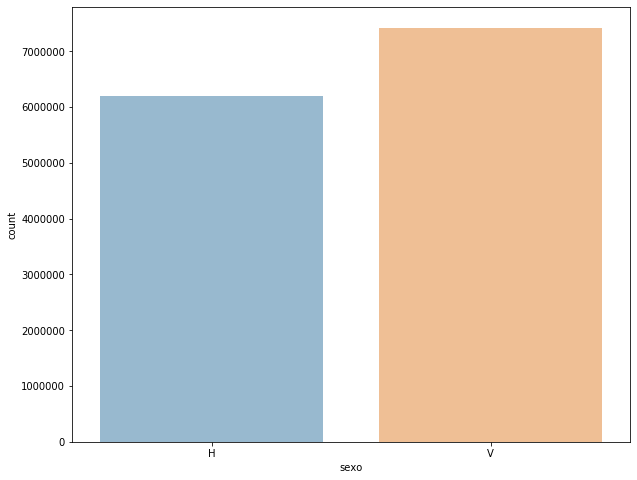

--------------------------------------------------
col: age


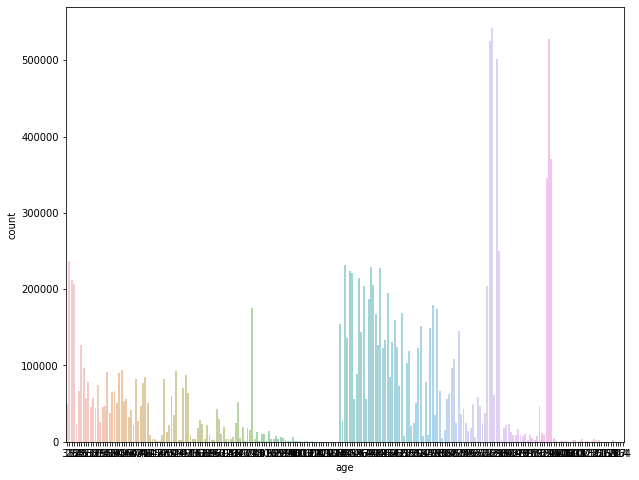

--------------------------------------------------
col: fecha_alta


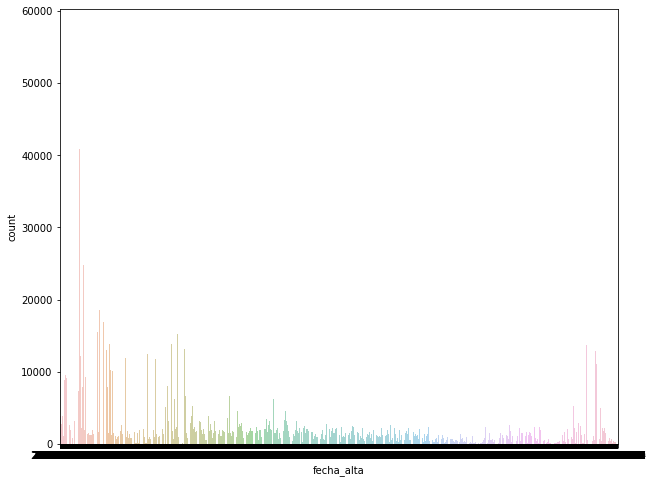

--------------------------------------------------
col: ind_nuevo


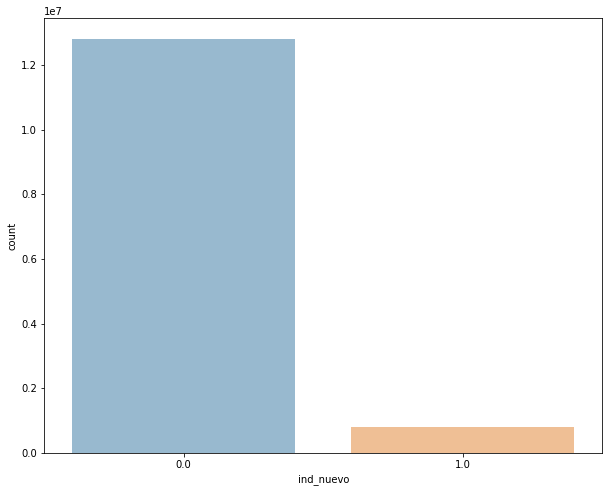

--------------------------------------------------
col: antiguedad


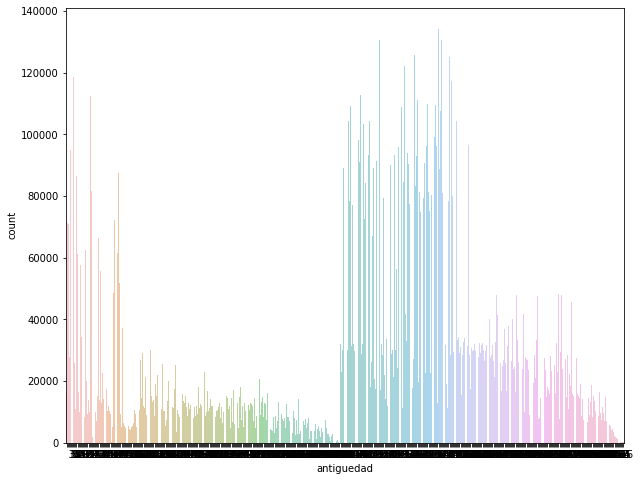

--------------------------------------------------
col: indrel


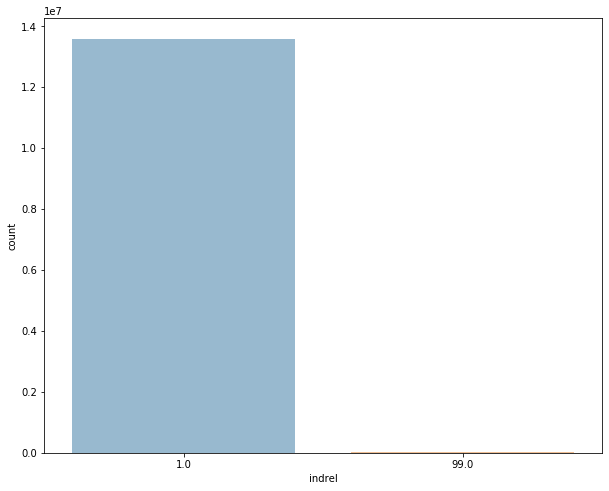

--------------------------------------------------
col: ult_fec_cli_1t


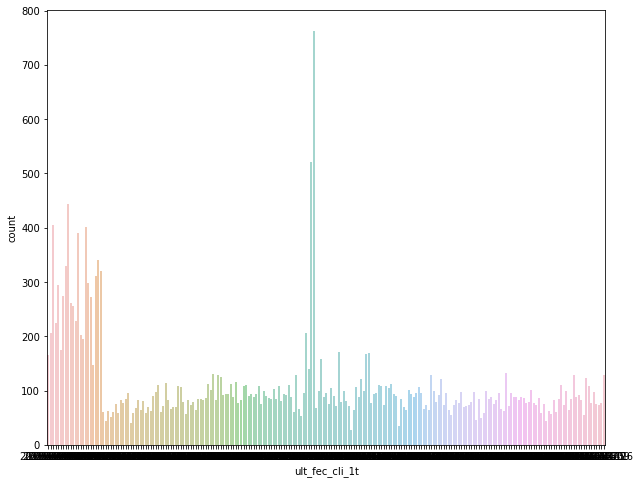

--------------------------------------------------
col: indrel_1mes


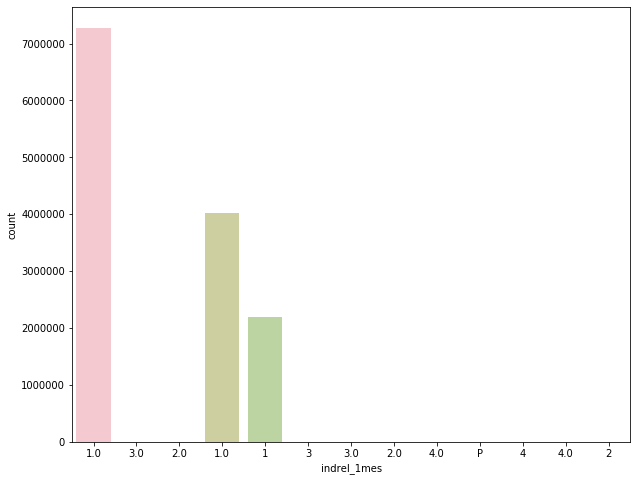

--------------------------------------------------
col: tiprel_1mes


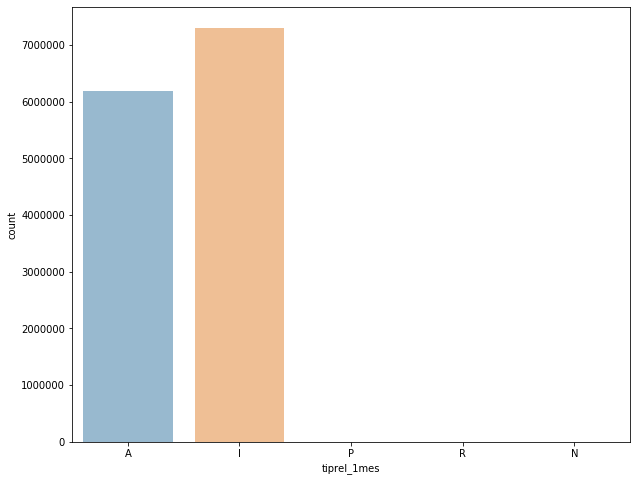

--------------------------------------------------
col: indresi


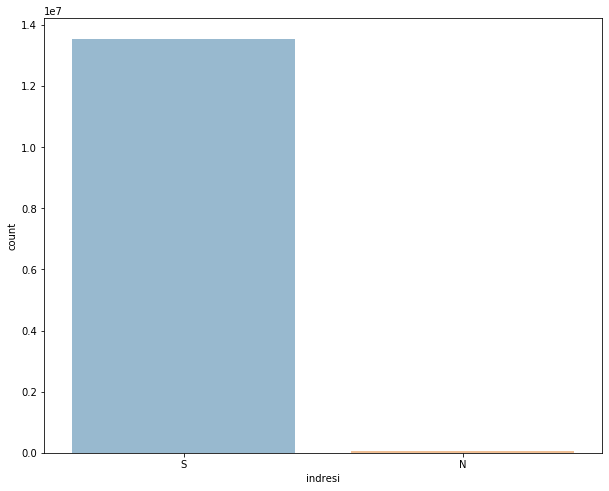

--------------------------------------------------
col: indext


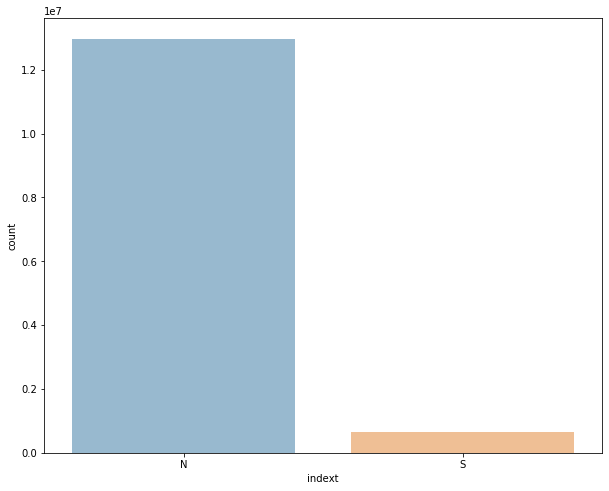

--------------------------------------------------
col: conyuemp


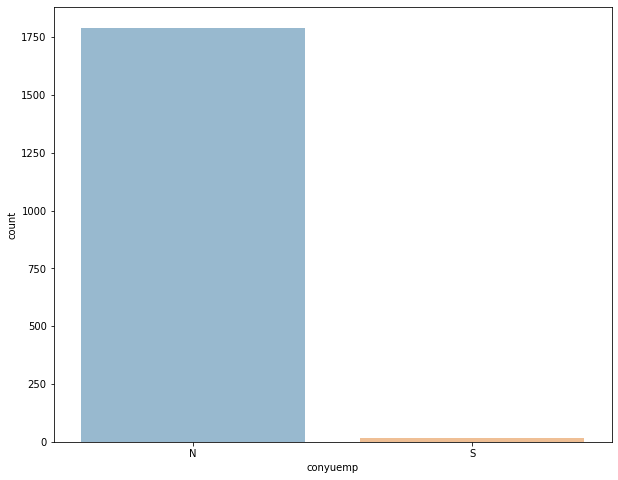

--------------------------------------------------
col: canal_entrada


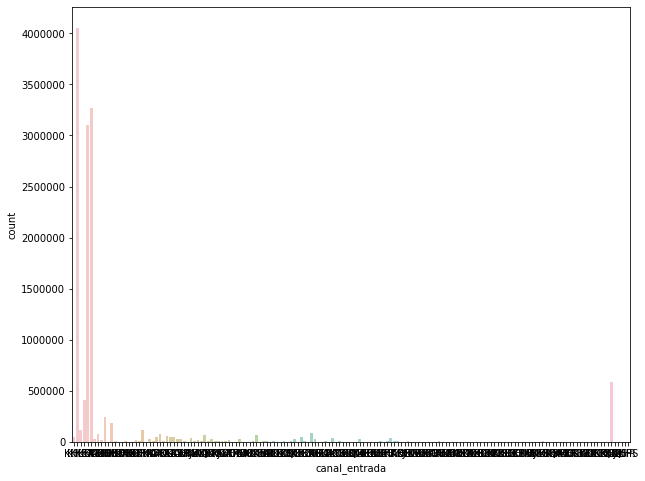

--------------------------------------------------
col: indfall


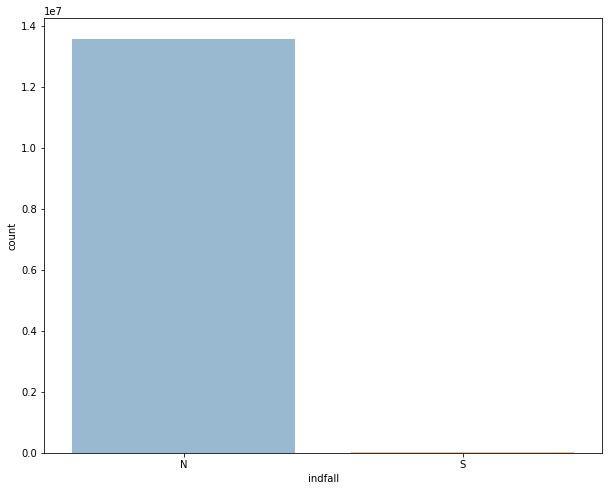

--------------------------------------------------
col: tipodom


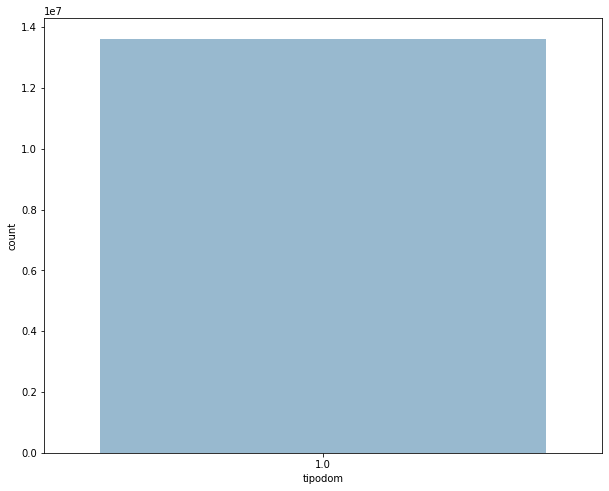

--------------------------------------------------
col: cod_prov


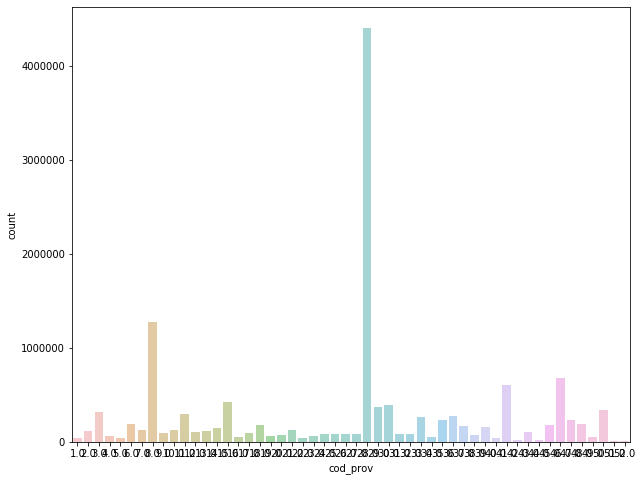

--------------------------------------------------
col: nomprov


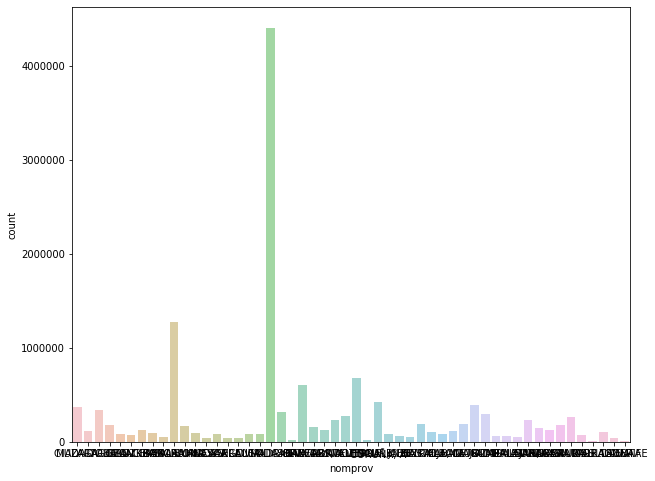

--------------------------------------------------
col: ind_actividad_cliente


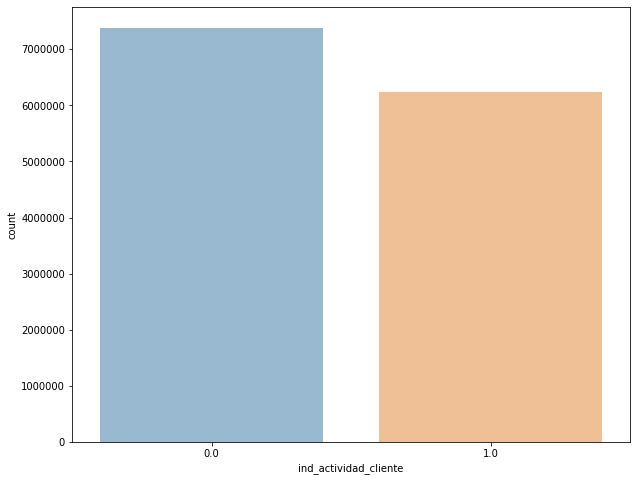

--------------------------------------------------
col: segmento


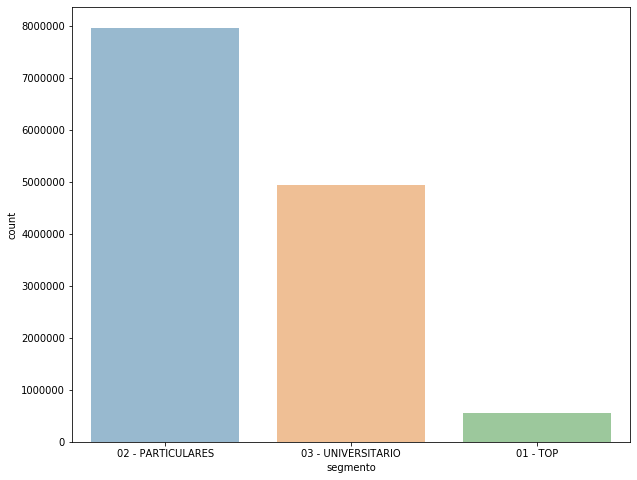

--------------------------------------------------
col: ind_ahor_fin_ult1


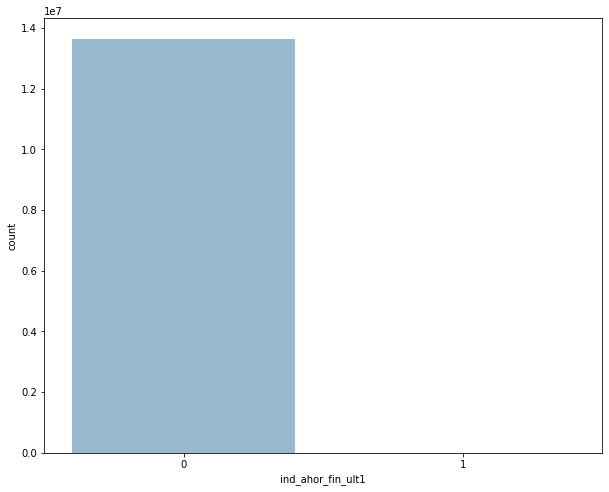

--------------------------------------------------
col: ind_aval_fin_ult1


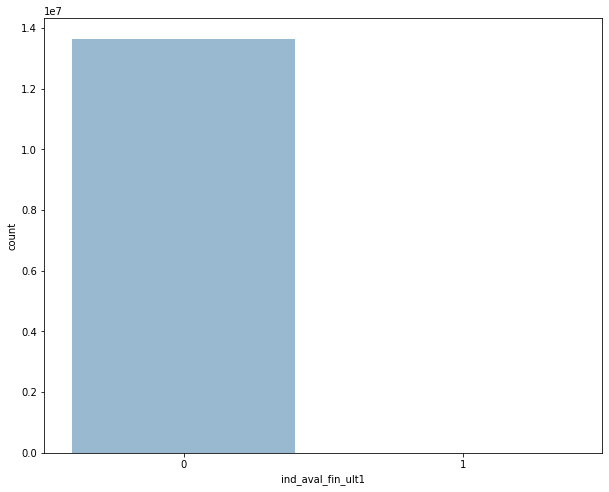

--------------------------------------------------
col: ind_cco_fin_ult1


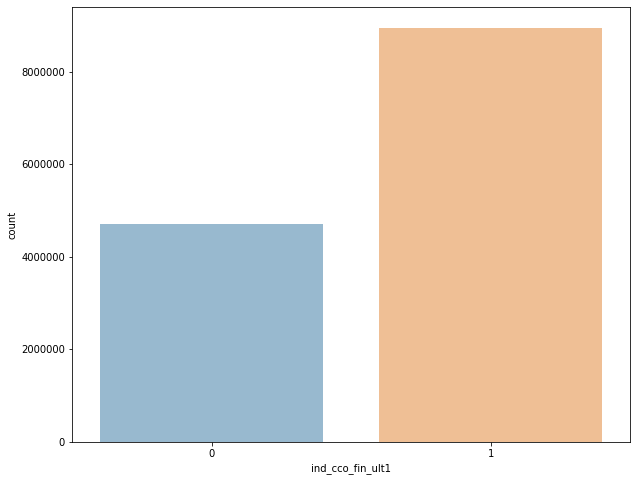

--------------------------------------------------
col: ind_cder_fin_ult1


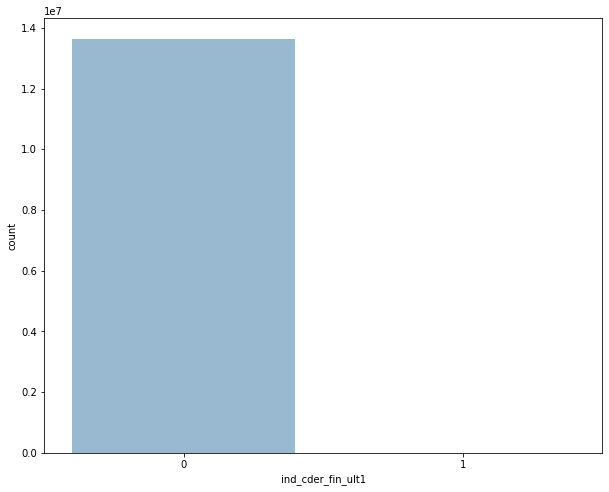

--------------------------------------------------
col: ind_cno_fin_ult1


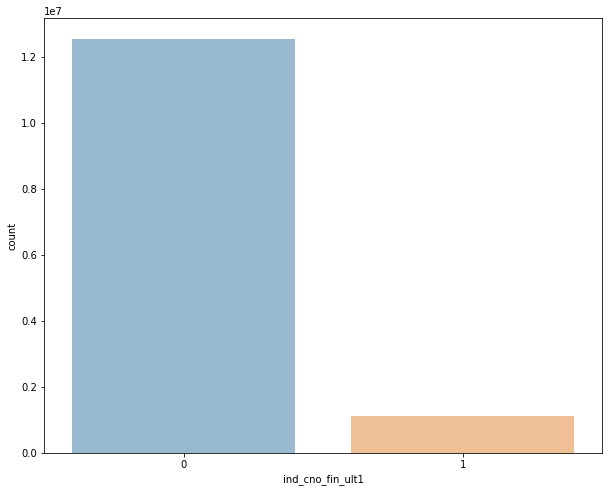

--------------------------------------------------
col: ind_ctju_fin_ult1


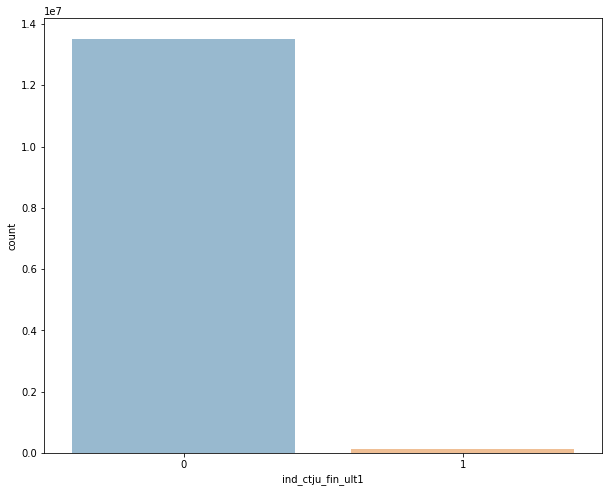

--------------------------------------------------
col: ind_ctma_fin_ult1


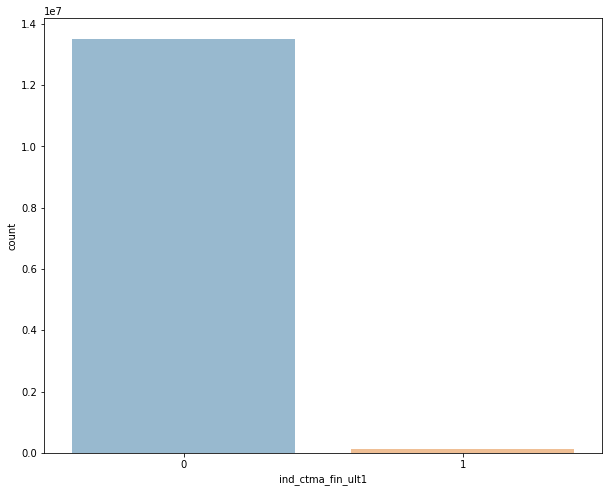

--------------------------------------------------
col: ind_ctop_fin_ult1


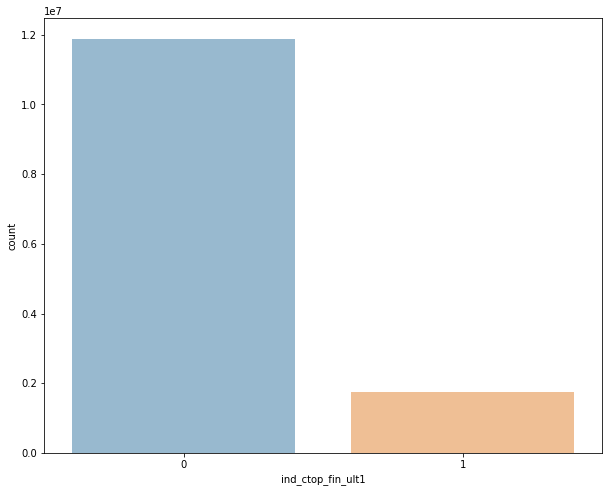

--------------------------------------------------
col: ind_ctpp_fin_ult1


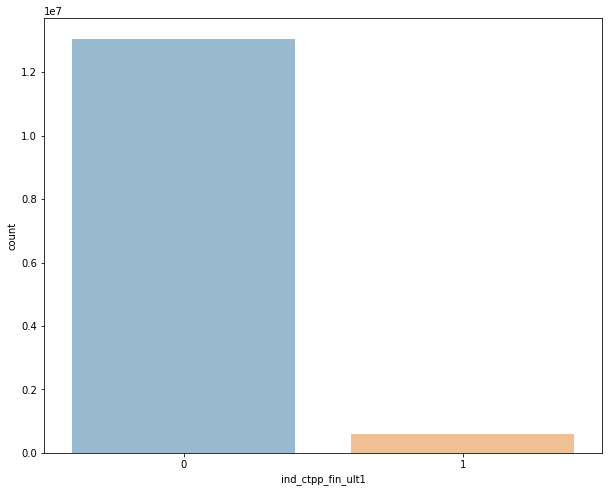

--------------------------------------------------
col: ind_deco_fin_ult1


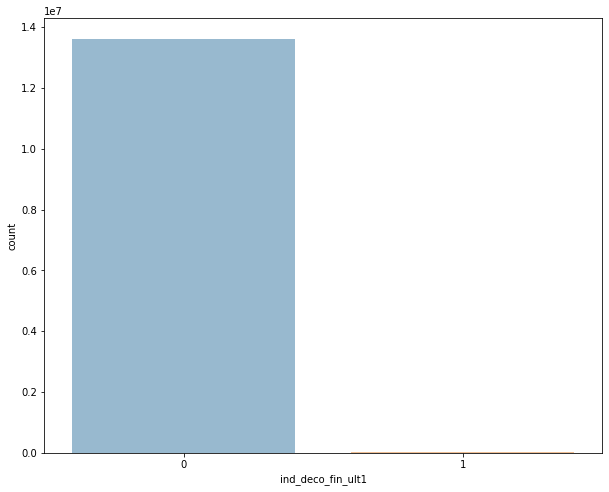

--------------------------------------------------
col: ind_deme_fin_ult1


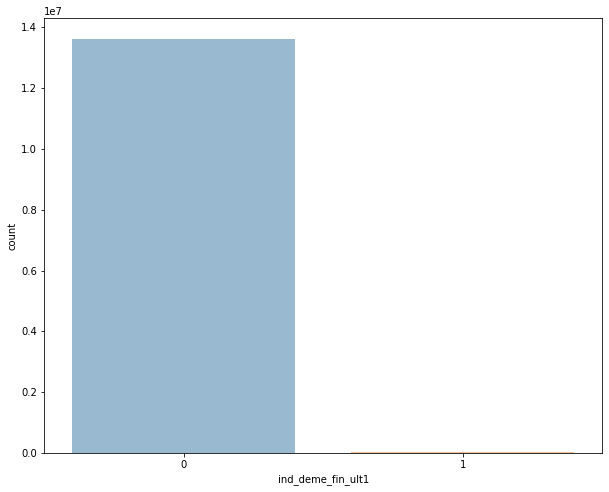

--------------------------------------------------
col: ind_dela_fin_ult1


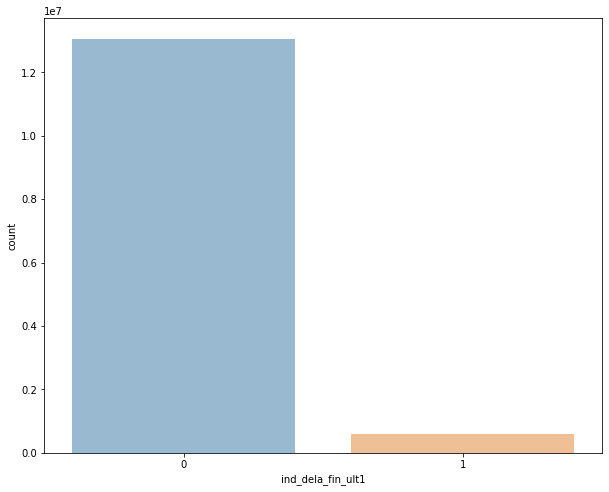

--------------------------------------------------
col: ind_ecue_fin_ult1


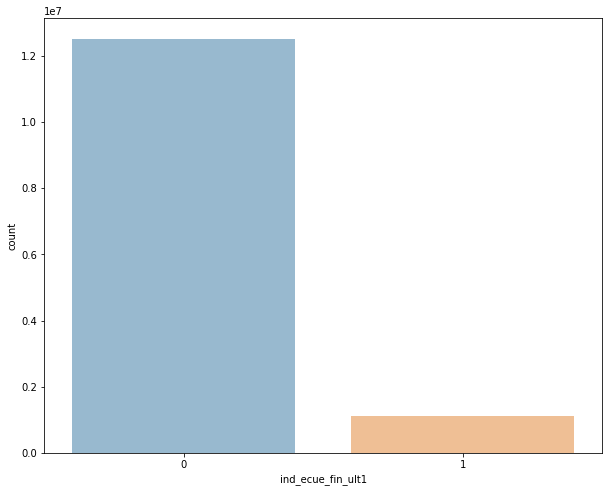

--------------------------------------------------
col: ind_fond_fin_ult1


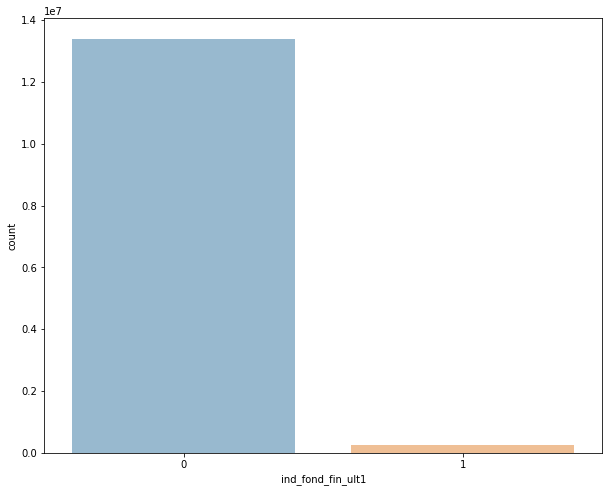

--------------------------------------------------
col: ind_hip_fin_ult1


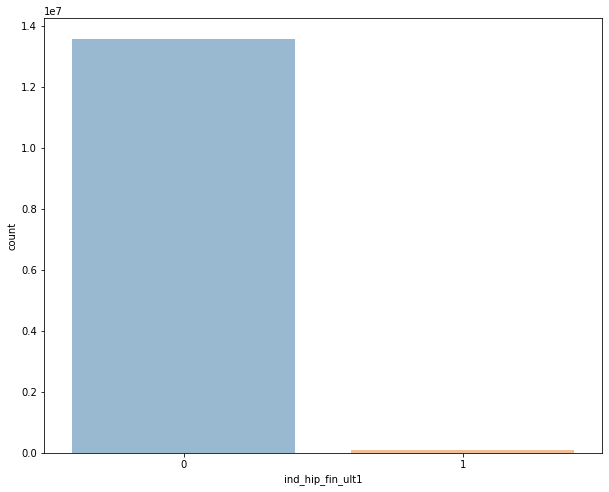

--------------------------------------------------
col: ind_plan_fin_ult1


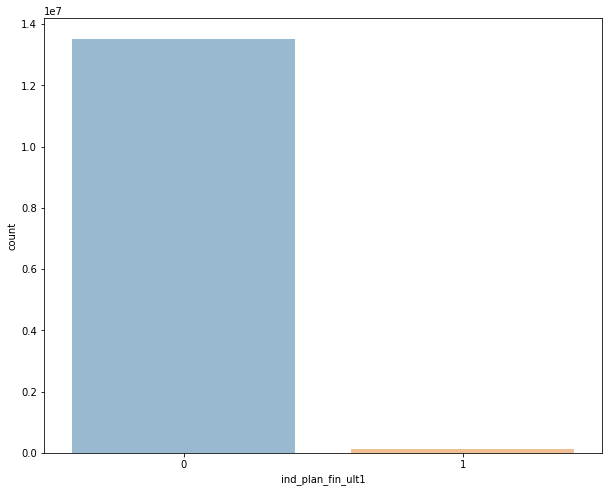

--------------------------------------------------
col: ind_pres_fin_ult1


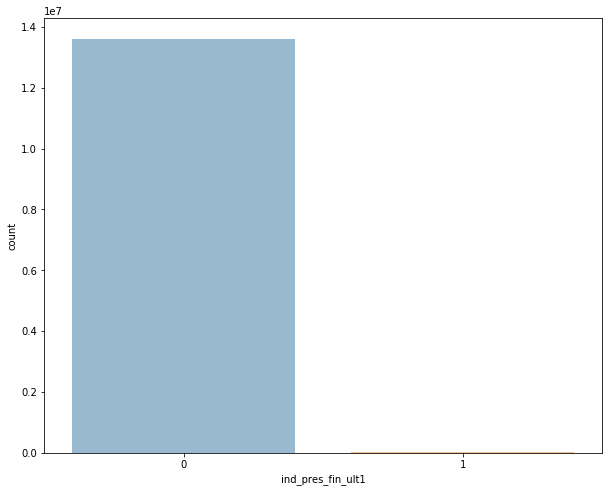

--------------------------------------------------
col: ind_reca_fin_ult1


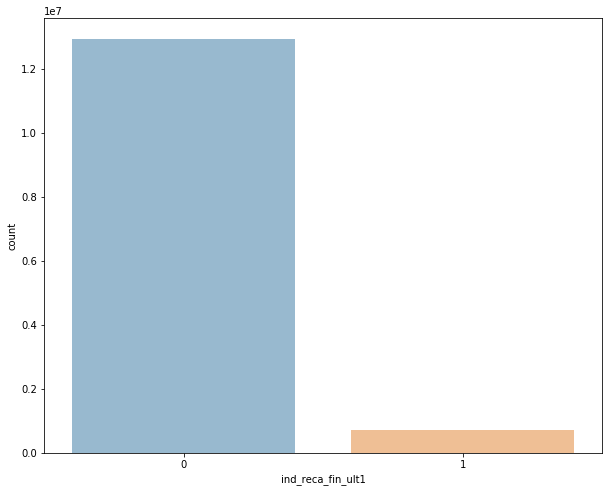

--------------------------------------------------
col: ind_tjcr_fin_ult1


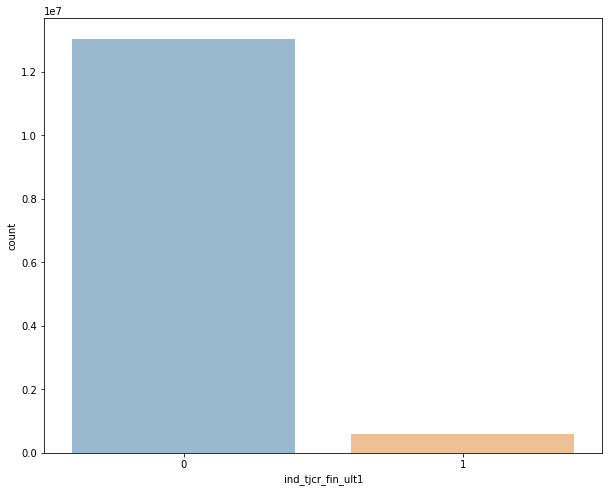

--------------------------------------------------
col: ind_valo_fin_ult1


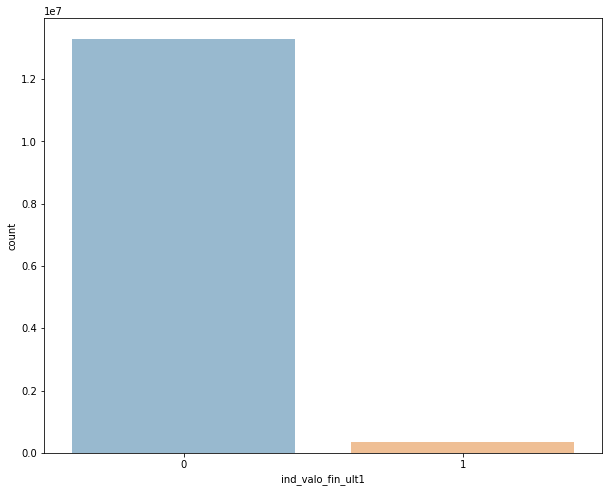

--------------------------------------------------
col: ind_viv_fin_ult1


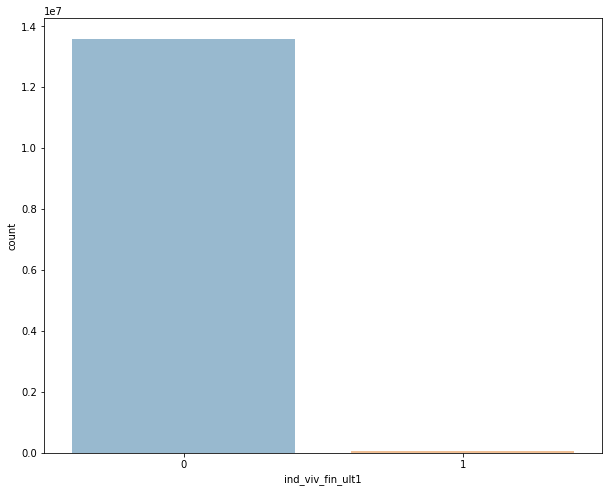

--------------------------------------------------
col: ind_nomina_ult1


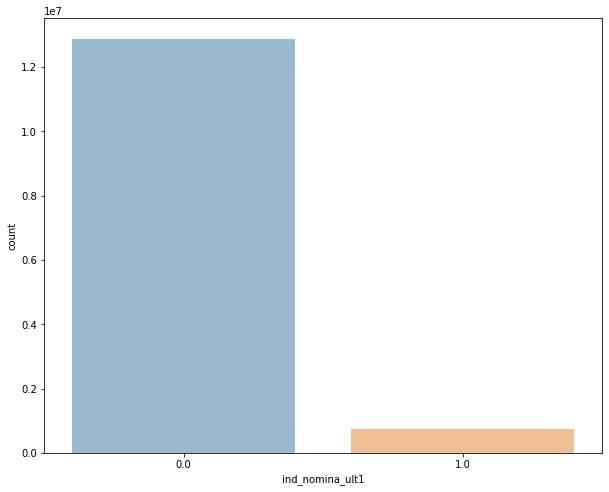

--------------------------------------------------
col: ind_nom_pens_ult1


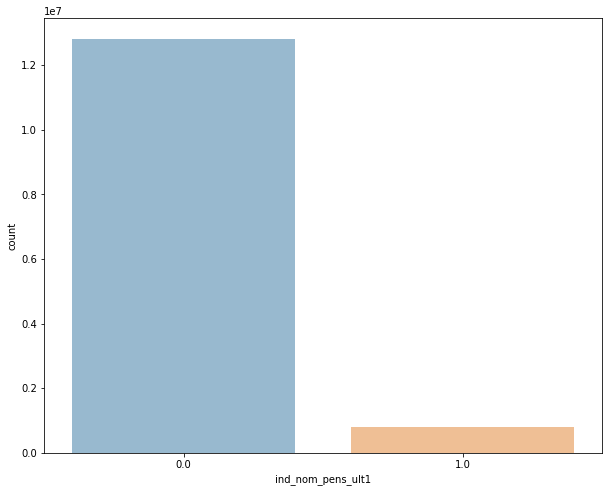

--------------------------------------------------
col: ind_recibo_ult1


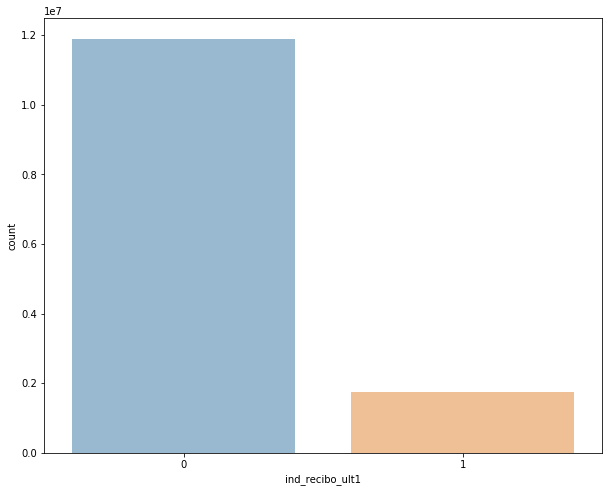

In [0]:
skip_cols = ['ncodpers', 'renta']
for col in trn.columns:
    if col in skip_cols:
        continue
    print('-'*50)
    print('col:',col)

    f, ax = plt.subplots(figsize=(10,8))
    sns.countplot(x=col,data=trn,alpha=0.5)
    plt.show()